Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


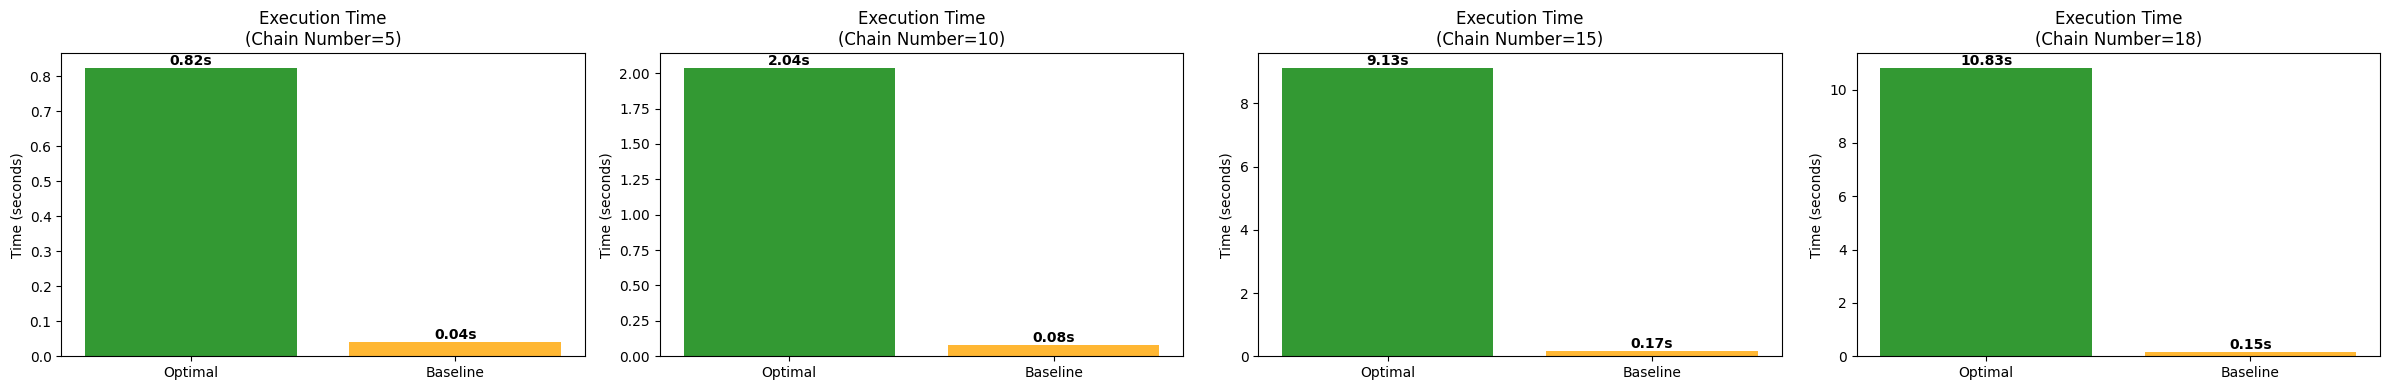

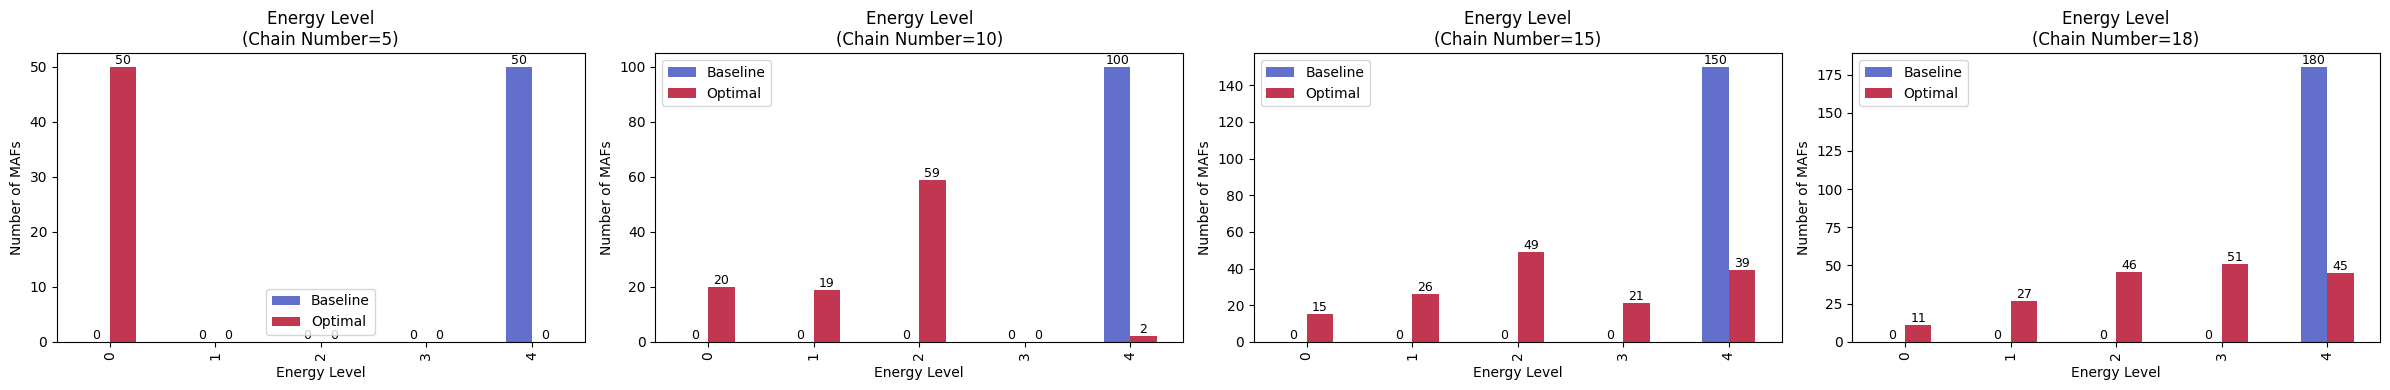

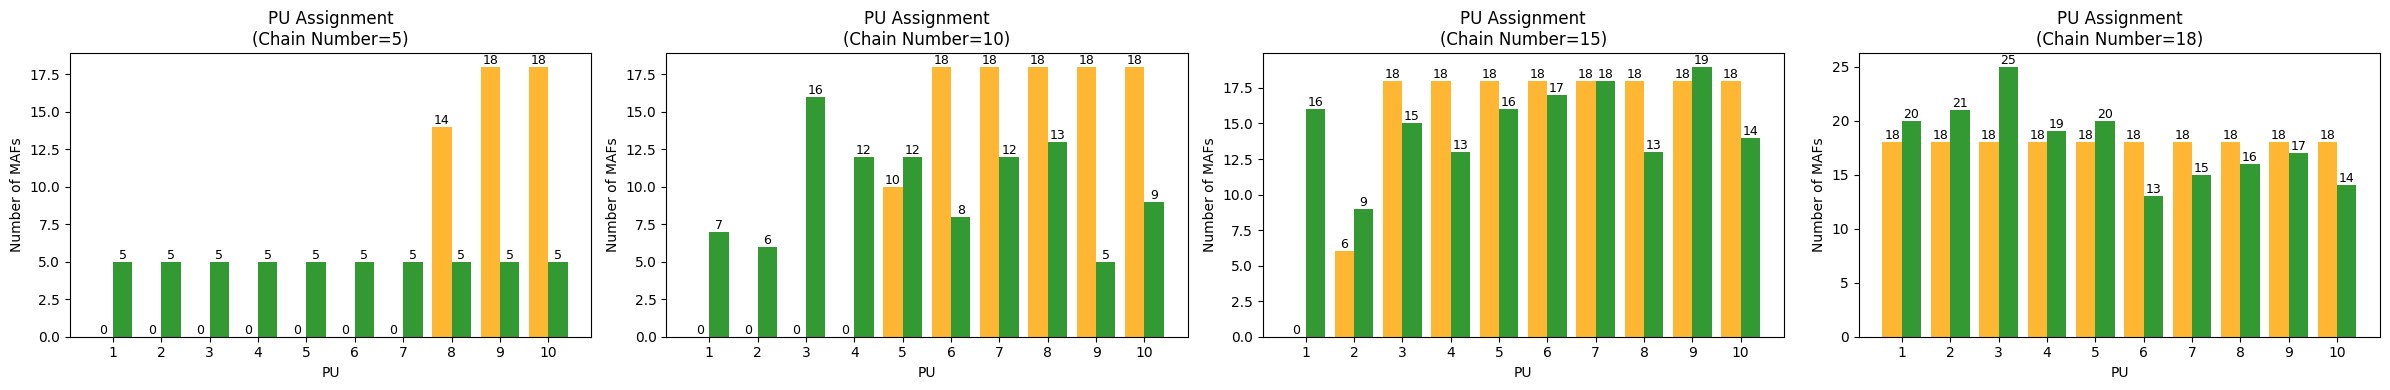

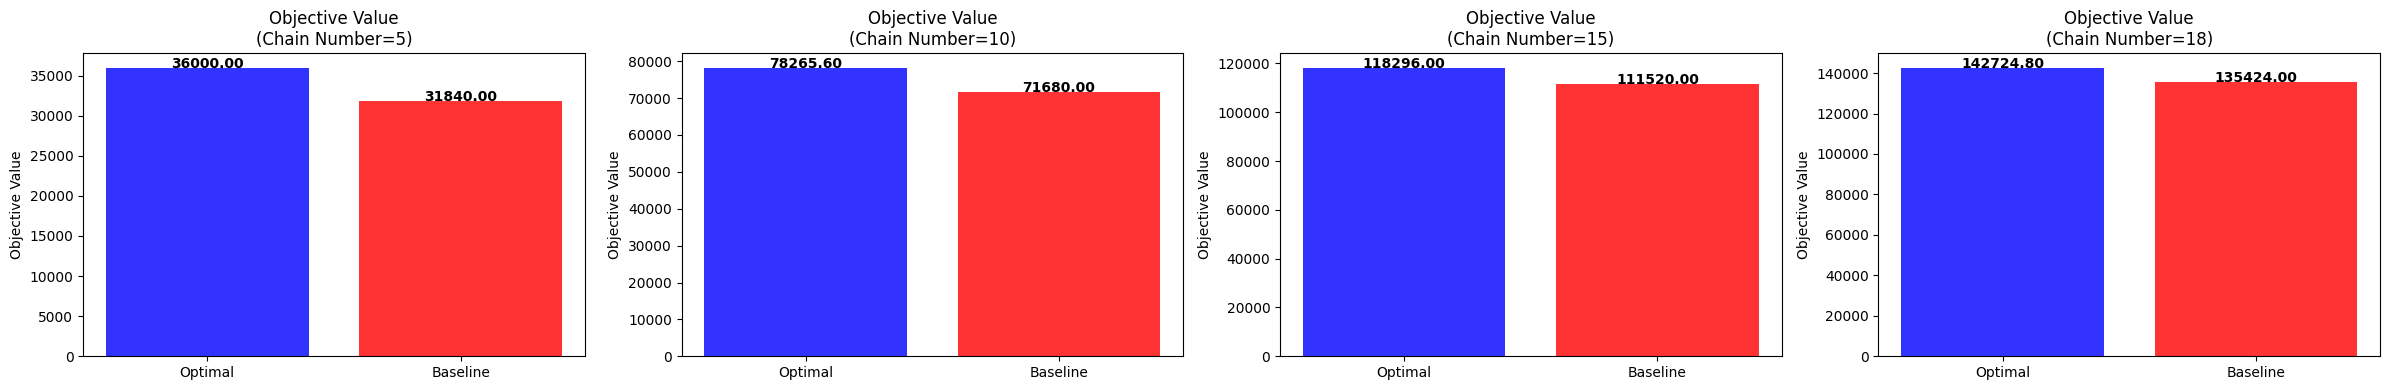

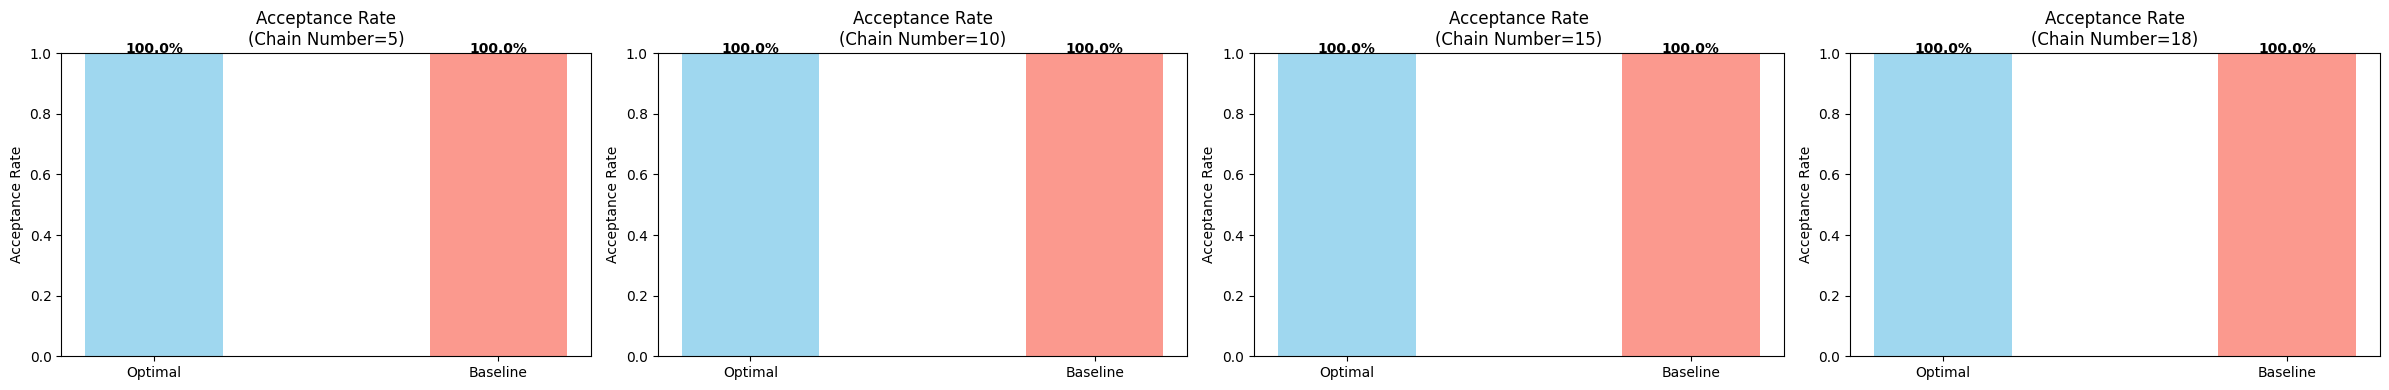

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [1200] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1200] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 14000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption

# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        #  Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        #  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources (corrected version)
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])


    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

chain_numbers = [5, 10, 15, 18]
test_param_list = chain_numbers
test_param_name = "Chain Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, num_chains in enumerate(test_param_list):

    
    chain_length = 10
    n = num_chains * chain_length
    chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}

    #
    L_max = [150] * num_chains  

    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: num_chains,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === Execution Time ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={num_chains})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={num_chains})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # 🚩 添加数值标注
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={num_chains})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # 🚩 添加数值标注
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={num_chains})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

# 布局调整
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()

plt.show()

Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10

=== PU详细能耗分析 ===
PU 1: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 2: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 3: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 4: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 5: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 6: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 7: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 8: execution_time=100.00, idle_time=300.00, U=25.00%, PU能耗=4000.00
PU 9: execution_time=400.00, idle_time=0.00, U=100.00%, PU能耗=4000.00
PU 10: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00

=== PU详细能耗分析 ===
PU 1: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 2: execution_time=0.00, idle_time=400.00, U=0.00%, PU能耗=4000.00
PU 3: execution_time=0

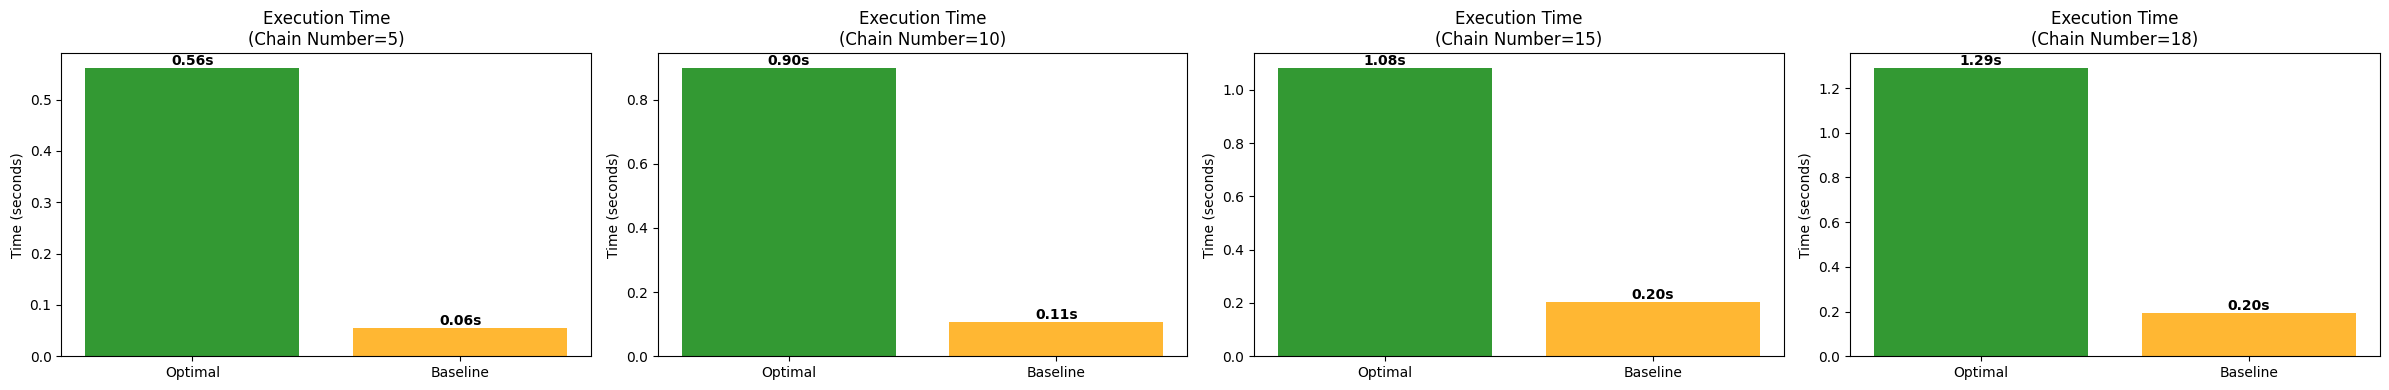

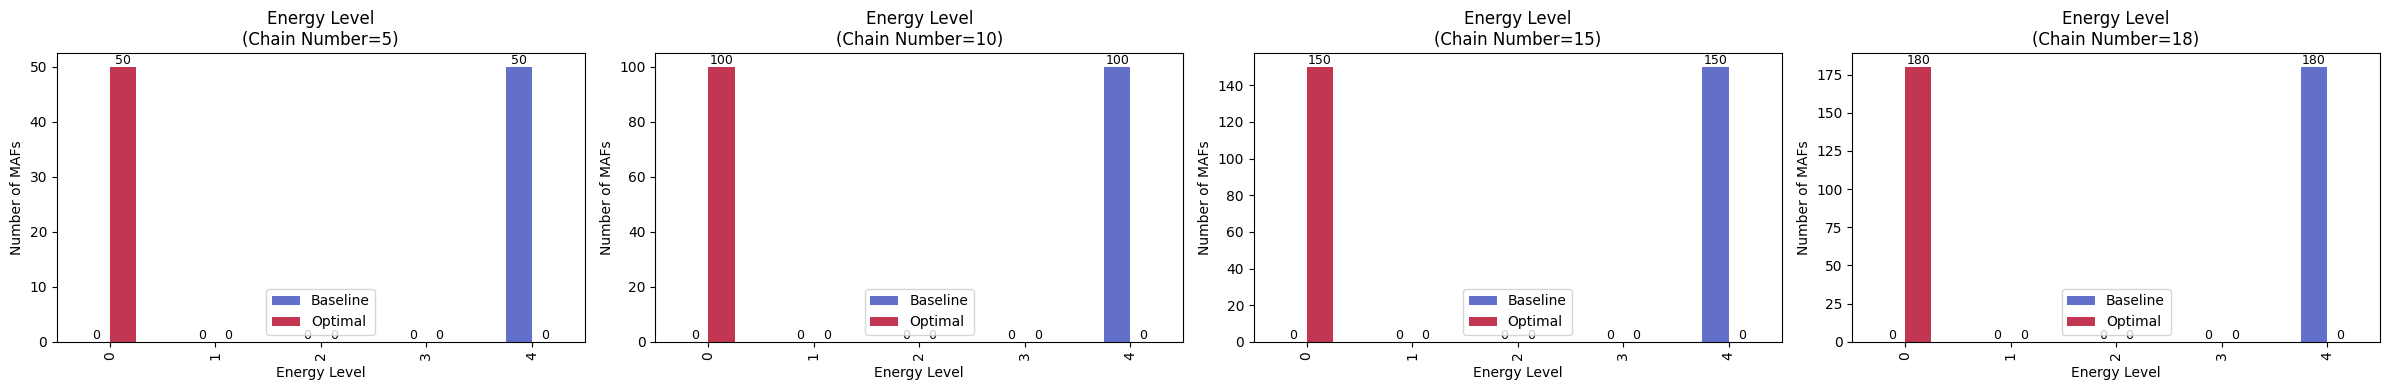

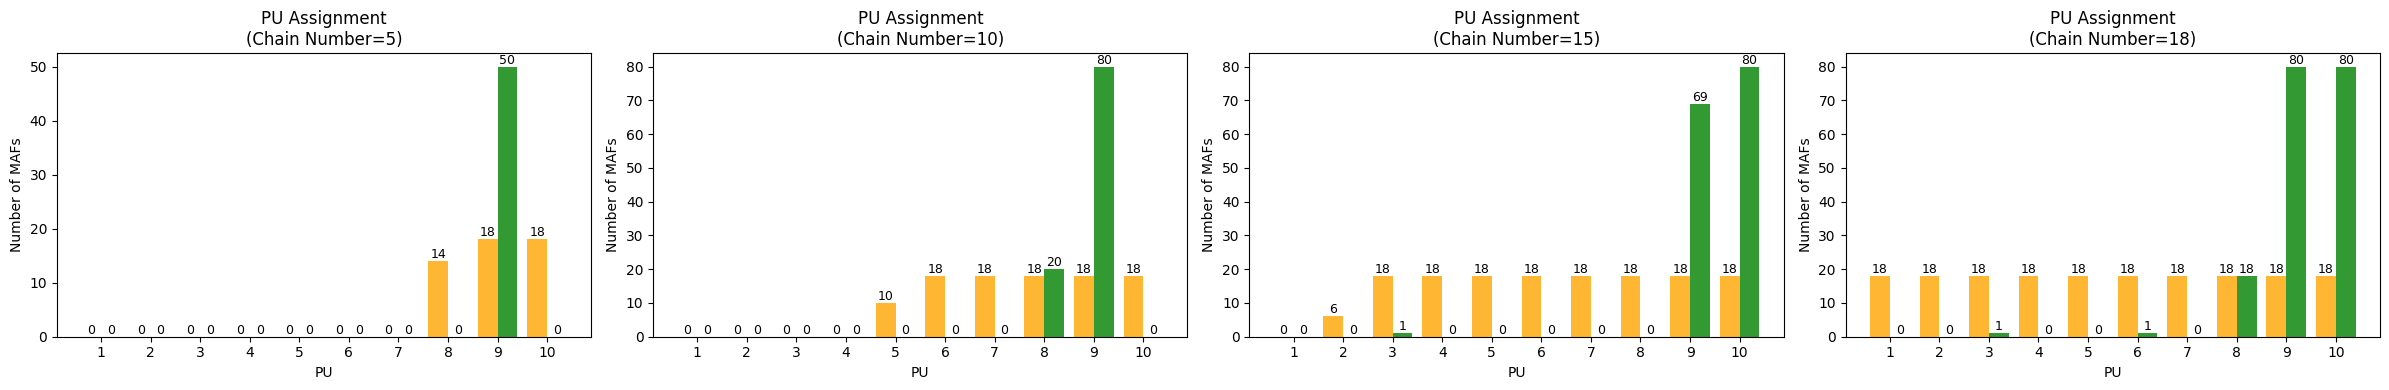

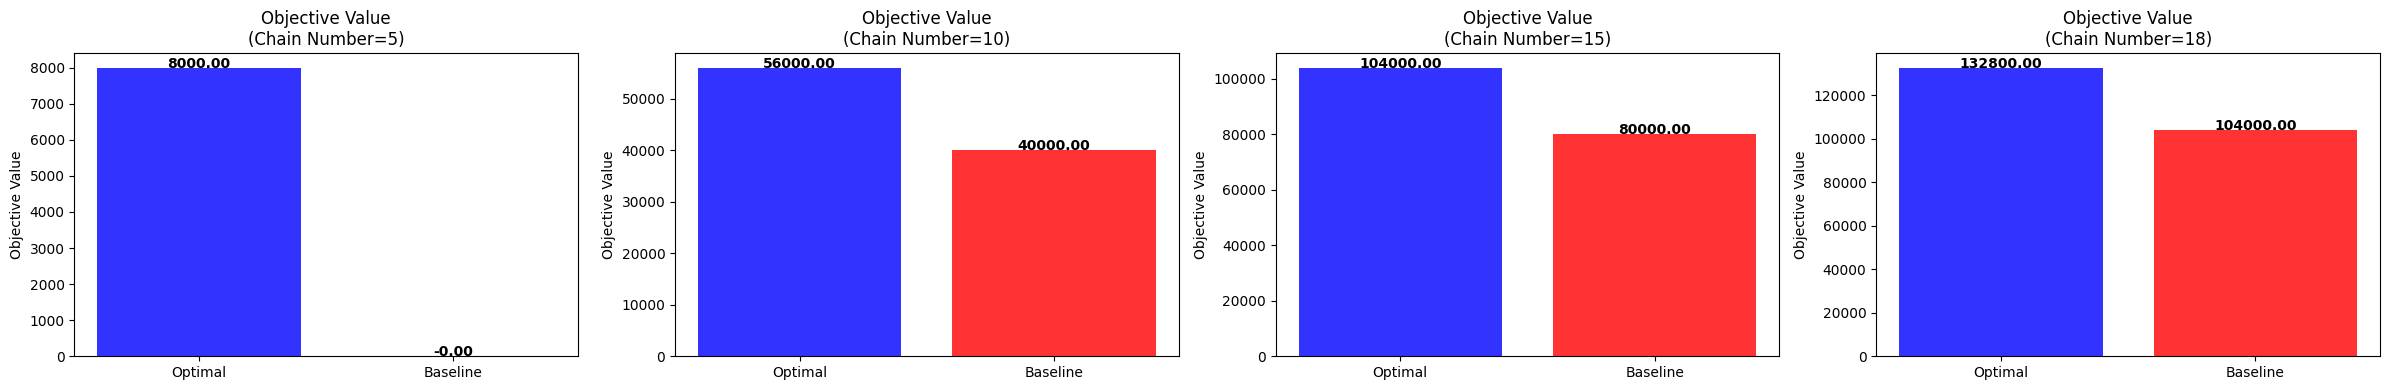

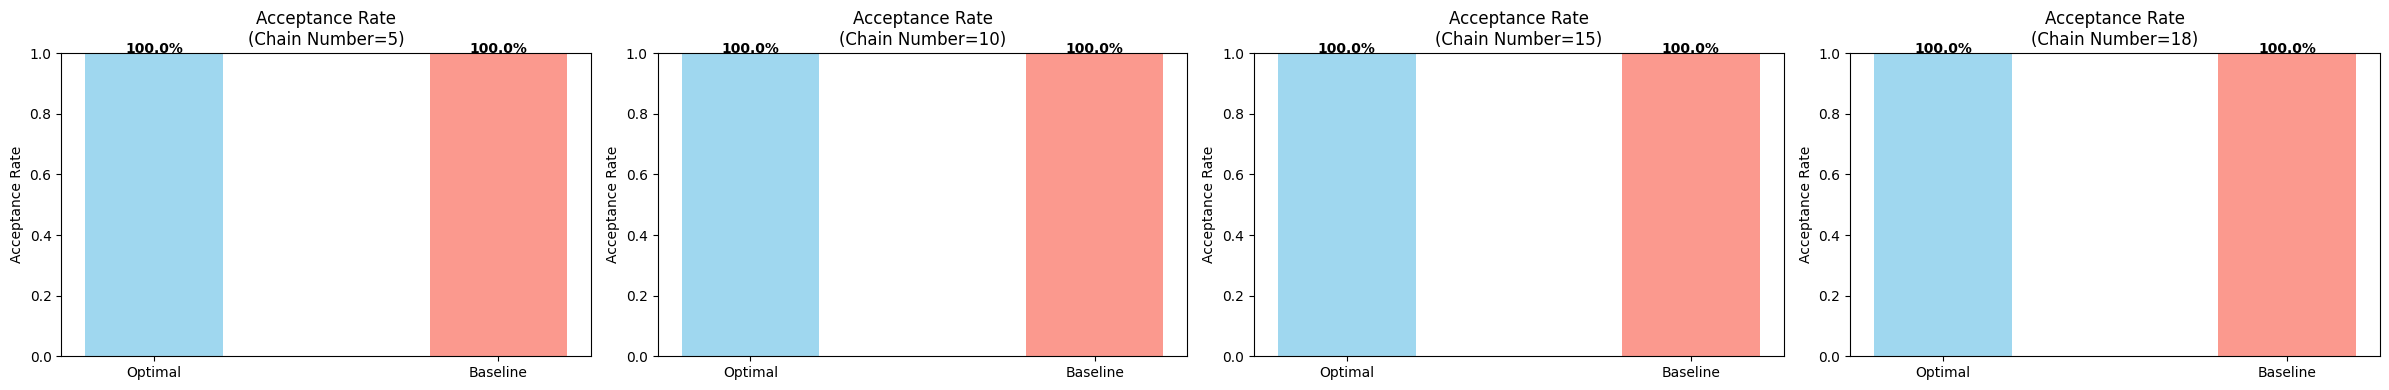

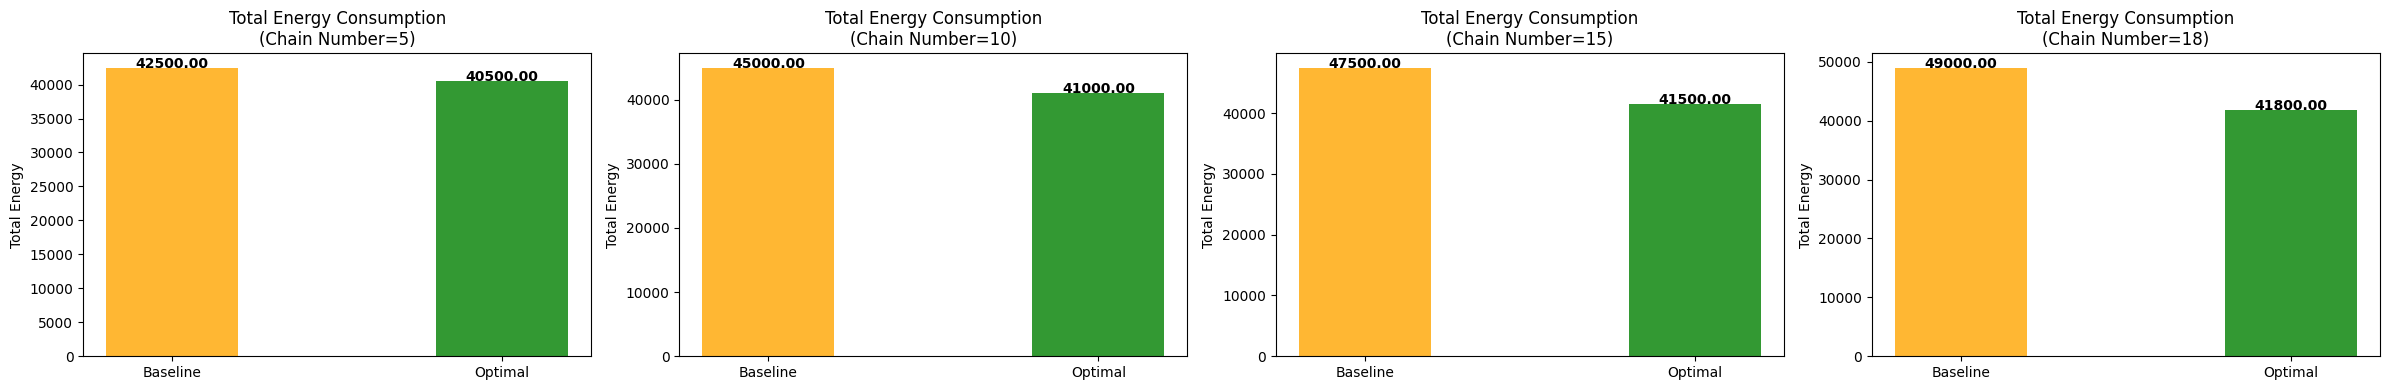

In [ ]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [5000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1200] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 14000  # Total system resource capacity
P_idle = [10] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption

# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [150] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]  # 任务链 k
        for i in chain:
            # 任务链 k 只有在所有包含的任务 i 运行时才能运行
            model.addConstr(z_chain_k[k] <= delta[i])

        # 如果任务链失效，则链上的所有任务也必须失效
        for i in chain:
            model.addConstr(delta[i] <= z_chain_k[k])

        # 计算任务链的执行时间
        execution_time_sum = quicksum(
            quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain
        )
        communication_delay = len(chain) - 1  

        # 任务链的端到端时延约束
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # 确保PU执行时间不超过T_total
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n)) <= T_total,
            name=f"PU_TimeLimit_{j}"
        )


    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        idle_time = T_total - execution_time  
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j]*idle_time + (P_max[j]-P_idle[j])*U_j[j]*T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # 添加调试信息
        print("\n=== PU详细能耗分析 ===")
        for j in range(m):
            execution_time = sum(
                w[i, j].X * sum(y[i, k].X * L_levels[k] for k in range(K)) for i in range(n)
            )
            idle_time = T_total - execution_time
            U = execution_time / T_total
            E_pu_value = model.getVarByName(f"E_PU[{j}]").X
            print(f"PU {j+1}: execution_time={execution_time:.2f}, idle_time={idle_time:.2f}, U={U:.2%}, PU能耗={E_pu_value:.2f}")
    else:
        print("模型未找到最优解！")

    return model if model.status == GRB.OPTIMAL else None



# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=100, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=100, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)


def calculate_total_energy(model):
    if model is None:
        return 0, 0

    maf_energy = sum(
        model.getVarByName(f"y[{i},{e}]").X * E_levels[e]
        for i in range(n) for e in range(K)
    )

    pu_energy = sum(
        model.getVarByName(f"E_PU[{j}]").X
        for j in range(m)
    )

    return maf_energy + pu_energy


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

chain_numbers = [5, 10, 15, 18]
test_param_list = chain_numbers
test_param_name = "Chain Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_total_energy, axes_total_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, num_chains in enumerate(test_param_list):

    
    chain_length = 10
    n = num_chains * chain_length
    chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}

    #
    L_max = [150] * num_chains  

    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: num_chains,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === Execution Time ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={num_chains})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={num_chains})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # 🚩 添加数值标注
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={num_chains})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # 🚩 添加数值标注
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={num_chains})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

    optimal_total_energy = calculate_total_energy(optimal_model)
    baseline_total_energy = calculate_total_energy(baseline_model)

    axes_total_energy[idx].bar(
        ["Baseline", "Optimal"],
        [baseline_total_energy, optimal_total_energy],
        color=["orange", "green"],
        alpha=0.8,
        width=0.4
    )

    axes_total_energy[idx].set_title(f"Total Energy Consumption\n({test_param_name}={num_chains})")
    axes_total_energy[idx].set_ylabel("Total Energy")

    # 🚩 数值标注
    for i, v in enumerate([baseline_total_energy, optimal_total_energy]):
        axes_total_energy[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")


# 布局调整
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()
fig_total_energy.tight_layout()
plt.show()

Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10
🔍 MAF Task Acceptance Rate: 1.00
🔍 MAF Chain Acceptance Rate: 1.00
🔍 MAF Task Acceptance Rate: 1.00
🔍 MAF Chain Acceptance Rate: 1.00
🔍 MAF Task Acceptance Rate: 1.00
🔍 MAF Chain Acceptance Rate: 1.00
🔍 MAF Task Acceptance Rate: 1.00
🔍 MAF Chain Acceptance Rate: 1.00


NameError: name 'calculate_acceptance_rate' is not defined

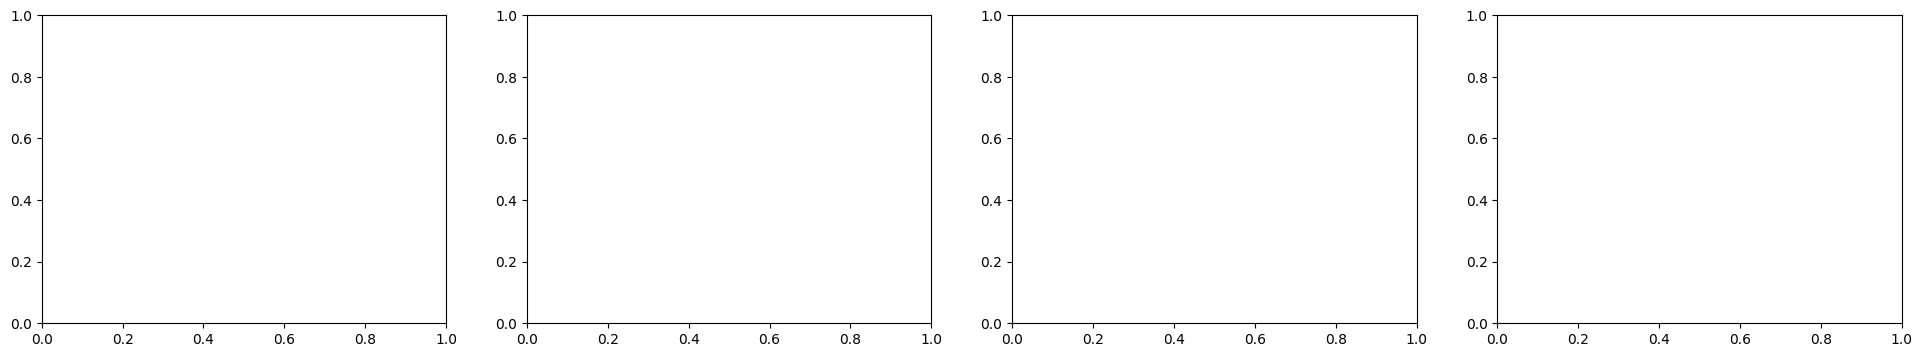

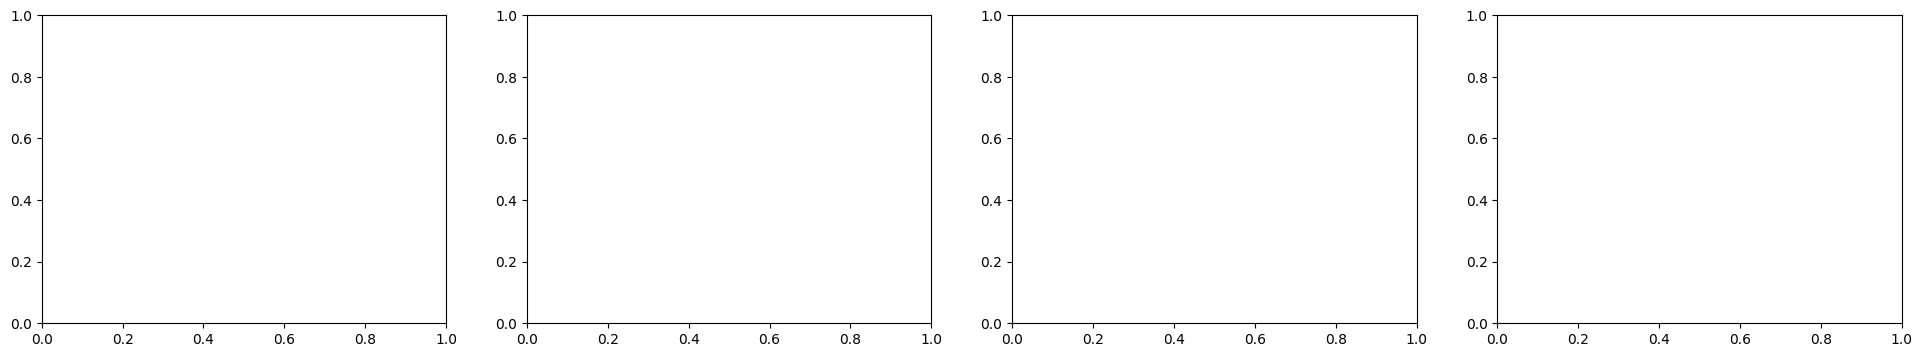

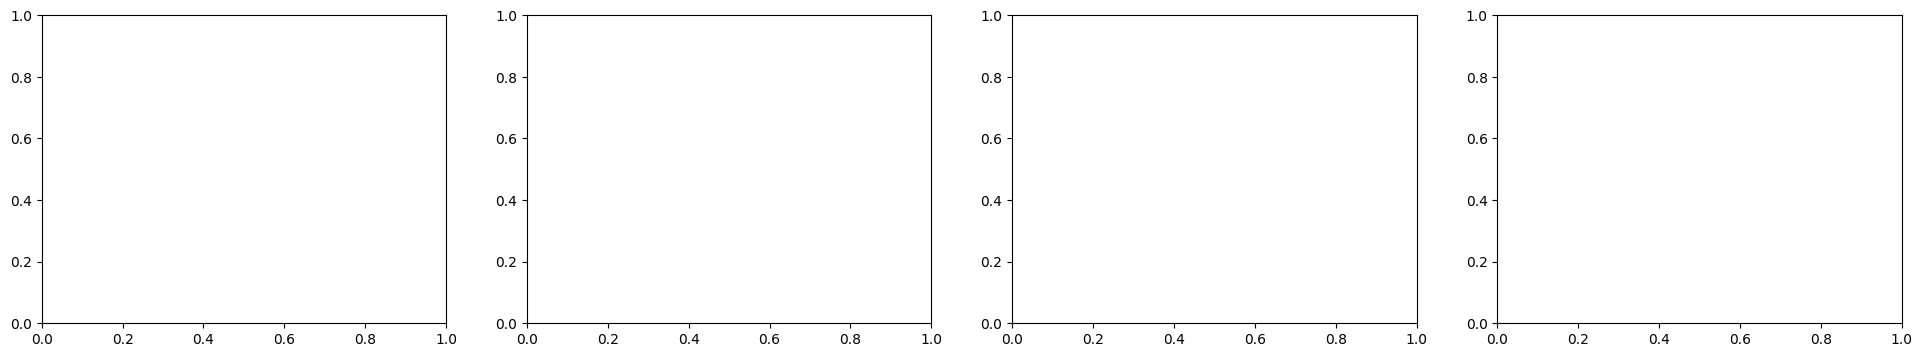

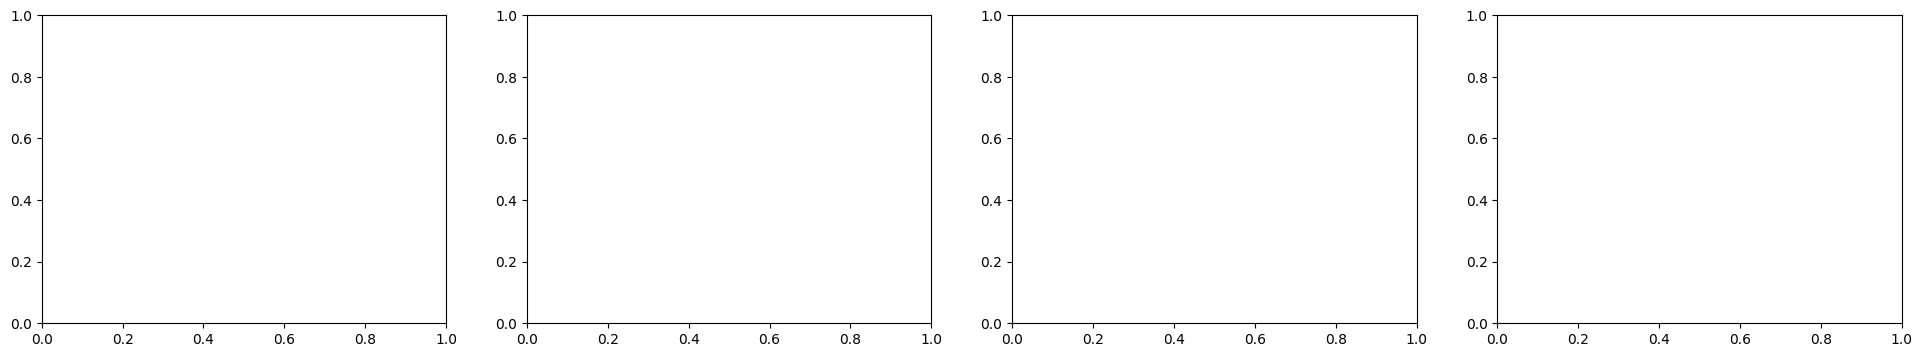

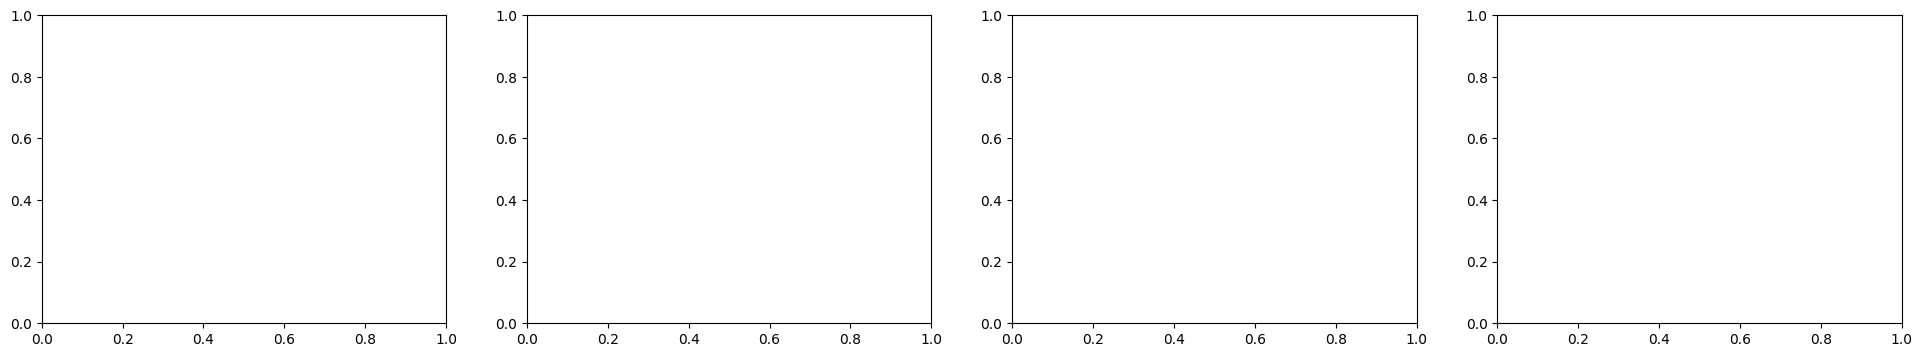

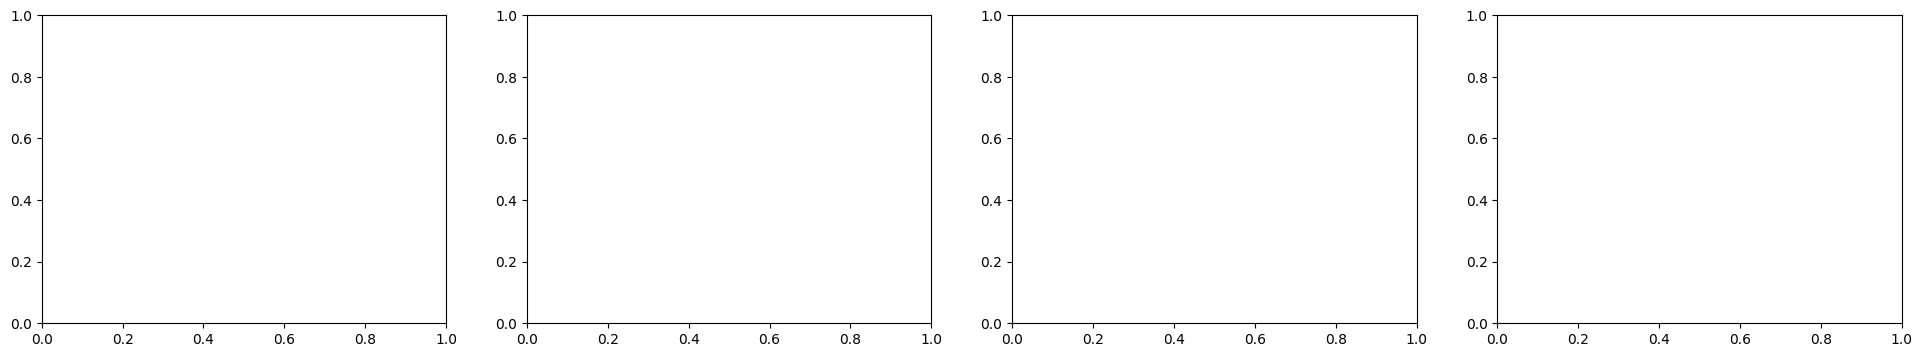

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [6000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [1200] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 14000  # Total system resource capacity
P_idle = [10] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption

# Task Chains
num_chains = 10
chain_length = 10
chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}
L_max = [50] * num_chains
acceptance_rate_target = 0.8  # Acceptance Rate target


def safe_get(var):
    return var.X if (var is not None and hasattr(var, 'X')) else 0

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8



def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")  # 任务是否激活
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")  # 任务在哪个 PU 上运行
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")  # 任务能耗等级
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")  # PU 能耗
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  # 任务链是否激活
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")  # PU 利用率
    L_iK = model.addVars(n, vtype=GRB.CONTINUOUS, name="L_iK")  # 任务执行时间

    # === 任务链 & 任务约束 ===
    for k in range(num_chains):
        chain = chain_tasks[k]

        # **自动决定哪些任务链可以被激活**
        model.addConstr(quicksum(delta[i] for i in chain) == z_chain_k[k] * len(chain), name=f"Chain_{k}_Activation")

        # 计算任务链执行时间
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) * delta[i] for i in chain)
        communication_delay = len(chain) - 1

        # 任务链端到端时延约束
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

        # **任务级约束**
        for i in chain:
            model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i], name=f"TaskAllocation_{i}")  # 任务必须被分配到一个 PU
            model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"TaskEnergyLevel_{i}")  # 任务必须选择一个能耗等级

            # **如果 `delta[i] = 0`，确保 `y[i, e] = 0`**
            for e in range(K):
                model.addConstr(y[i, e] <= delta[i], name=f"TaskEnergyLevelZero_{i}_{e}")

            # 计算任务的执行时间
            model.addConstr(L_iK[i] == quicksum(y[i, k] * L_levels[k] for k in range(K)), name=f"L_iK_Calc_{i}")

    # === Baseline 约束：任务始终选择最高能耗 ===
    if baseline:
        for i in range(n):
            model.addConstr(y[i, K-1] == delta[i], name=f"Baseline_MaxEnergy_{i}")

    # === PU 计算时间 & 资源限制 ===
    for j in range(m):
        execution_time = quicksum(w[i, j] * L_iK[i] for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)  # PU 利用率
        idle_time = T_total - execution_time  
        model.addConstr(E_PU[j] == P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * U_j[j] * T_total)  # PU 能耗
        model.addConstr(E_PU[j] <= E_PU_max[j])  # PU 最大能耗限制

    # === 计算资源限制 ===
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    # === 全系统资源限制 ===
    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # === 目标函数：最大化任务链 & 任务激活数，最小化能耗 ===
    obj = (
        alpha_1 * quicksum(z_chain_k[k] for k in range(num_chains))  # **最大化任务链激活**
        + alpha_2 * quicksum(delta[i] for i in range(n))  # **最大化任务激活**
        - alpha_3 * quicksum(E_PU[j] for j in range(m))  # **最小化能耗**
    )
    model.setObjective(obj, GRB.MAXIMIZE)

    # === 运行 Gurobi 优化 ===
    model.optimize()

    # === 计算 acceptance_rate ===
    if model.status == GRB.OPTIMAL:  
        activated_tasks = sum(
            delta[i].X for i in range(n) if delta[i].X is not None
        )
        activated_chains = sum(
            z_chain_k[k].X for k in range(num_chains) if z_chain_k[k].X is not None
        )
        acceptance_rate = activated_tasks / n  
        chain_acceptance_rate = activated_chains / num_chains

        print(f"🔍 MAF Task Acceptance Rate: {acceptance_rate:.2f}")
        print(f"🔍 MAF Chain Acceptance Rate: {chain_acceptance_rate:.2f}")
    else:
        print("❌ Gurobi 没有找到可行解，无法计算 `acceptance_rate`")
        return None

    return model



# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=100, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=100, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)


def calculate_total_energy(model):
    if model is None:
        return 0, 0

    maf_energy = sum(
        model.getVarByName(f"y[{i},{e}]").X * E_levels[e]
        for i in range(n) for e in range(K)
    )

    pu_energy = sum(
        model.getVarByName(f"E_PU[{j}]").X
        for j in range(m)
    )

    return maf_energy + pu_energy


# === MAF Chain Acceptance Rate ===
def calculate_task_acceptance_rate(model):
    if model is None:
        return 0
    accepted_tasks = sum(1 for i in range(n) if model.getVarByName(f"delta[{i}]").X > 0.5)
    return accepted_tasks / n  # 计算任务的激活比例


chain_numbers = [5, 10, 15, 18]
test_param_list = chain_numbers
test_param_name = "Chain Number"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_total_energy, axes_total_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, num_chains in enumerate(test_param_list):

    
    chain_length = 10
    n = num_chains * chain_length
    chain_tasks = {i: list(range(i * chain_length, (i + 1) * chain_length)) for i in range(num_chains)}

    #
    L_max = [150] * num_chains  

    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(1000, 4, 1, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(1000, 4, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: num_chains,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === Execution Time ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={num_chains})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={num_chains})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # 🚩 添加数值标注
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={num_chains})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # 🚩 添加数值标注
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={num_chains})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={num_chains})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

    optimal_total_energy = calculate_total_energy(optimal_model)
    baseline_total_energy = calculate_total_energy(baseline_model)

    axes_total_energy[idx].bar(
        ["Baseline", "Optimal"],
        [baseline_total_energy, optimal_total_energy],
        color=["orange", "green"],
        alpha=0.8,
        width=0.4
    )

    axes_total_energy[idx].set_title(f"Total Energy Consumption\n({test_param_name}={num_chains})")
    axes_total_energy[idx].set_ylabel("Total Energy")

    # 🚩 数值标注
    for i, v in enumerate([baseline_total_energy, optimal_total_energy]):
        axes_total_energy[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")


# 布局调整
fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()
fig_total_energy.tight_layout()
plt.show()

